In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Data Loading

In [2]:
import tensorflow as tf

main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train_dir

'/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  #color_mode='grayscale',
  image_size=(256, 256),
  batch_size=32)

Found 100000 files belonging to 2 classes.


In [5]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir, 
    seed=123,
    #color_mode='grayscale',
    image_size=(256, 256),
    batch_size=32)

Found 20000 files belonging to 2 classes.


In [6]:
print(train_ds.class_names)

['fake', 'real']


In [7]:
print(valid_ds.class_names)

['fake', 'real']


# Data Visualization

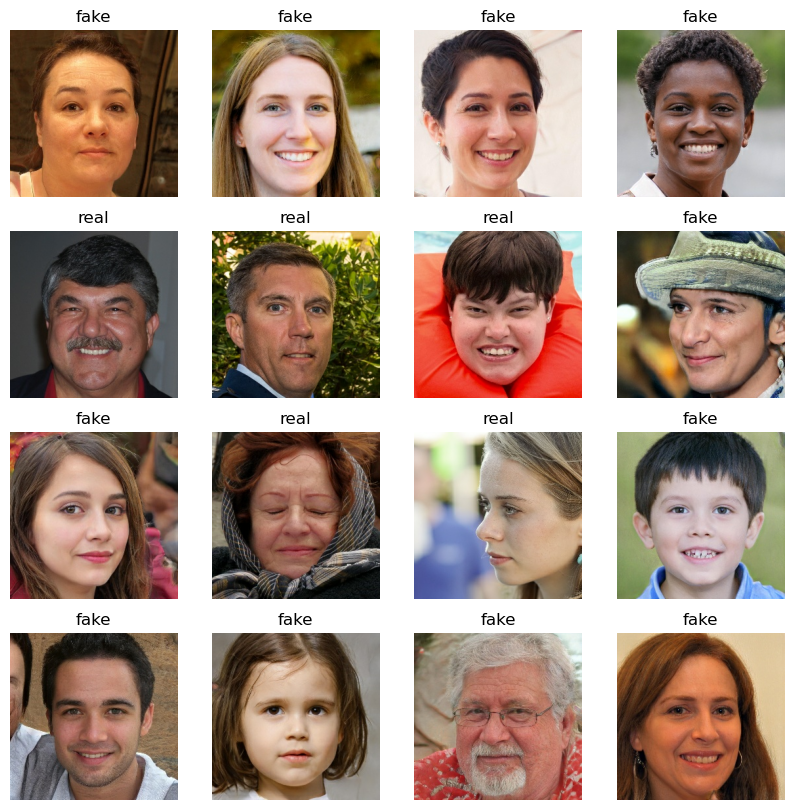

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Print the input shape: 
- 32 is the batch size, 
- 128 are the height and width, 
- 3 are the channels (rbg)

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


# Data Augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    #tf.keras.layers.Rescaling(1./255)
])

Visualize the data augmentation

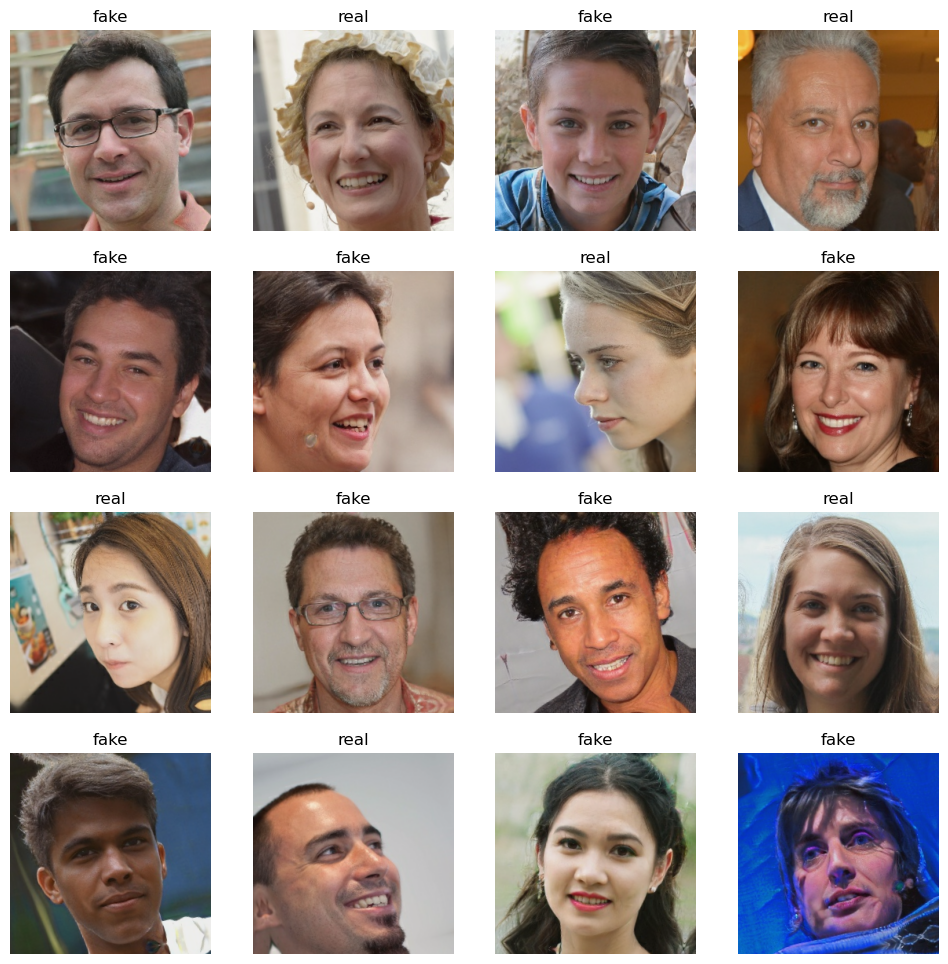

In [11]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_ds.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(X_batch_augmented[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[y_batch[i]])
        plt.axis("off")

plt.show()

# CNN architecture with DenseNet121 model

In [12]:
tf.keras.backend.clear_session()


densenet = tf.keras.applications.DenseNet121( weights=None, include_top=False, input_shape=(256,256,3))

rescaling = tf.keras.layers.Rescaling(1./255)

model = tf.keras.models.Sequential([ 
        data_augmentation, #augmentation layer
        rescaling, #rescaling layer
        densenet, #model architecture
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])



In [13]:
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Training

In [25]:
#fit the model
history = model.fit(train_ds, epochs = 10 , validation_data = valid_ds, validation_steps = 100, verbose=1)

Epoch 1/10
3125/3125 [==============================] - 824s 242ms/step - loss: 0.6335 - accuracy: 0.6368 - val_loss: 0.6261 - val_accuracy: 0.6559
Epoch 2/10
3125/3125 [==============================] - 758s 242ms/step - loss: 0.4962 - accuracy: 0.7585 - val_loss: 0.4353 - val_accuracy: 0.7944
Epoch 3/10
3125/3125 [==============================] - 758s 242ms/step - loss: 0.3863 - accuracy: 0.8261 - val_loss: 0.4198 - val_accuracy: 0.8066
Epoch 4/10
3125/3125 [==============================] - 758s 243ms/step - loss: 0.3070 - accuracy: 0.8682 - val_loss: 0.7224 - val_accuracy: 0.7484
Epoch 5/10
3125/3125 [==============================] - 754s 241ms/step - loss: 0.2429 - accuracy: 0.8984 - val_loss: 0.2672 - val_accuracy: 0.8919
Epoch 6/10
3125/3125 [==============================] - 761s 243ms/step - loss: 0.1966 - accuracy: 0.9205 - val_loss: 0.2785 - val_accuracy: 0.8844
Epoch 7/10
3125/3125 [==============================] - 763s 244ms/step - loss: 0.1597 - accuracy: 0.9364 - val_

In [26]:
model.save("./densenet_model.h5")

# Visualize the training

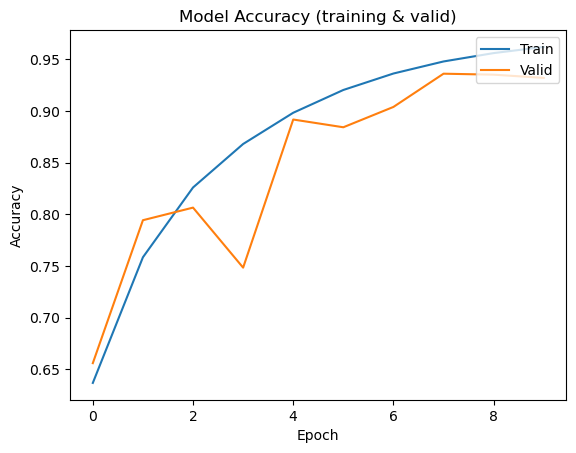

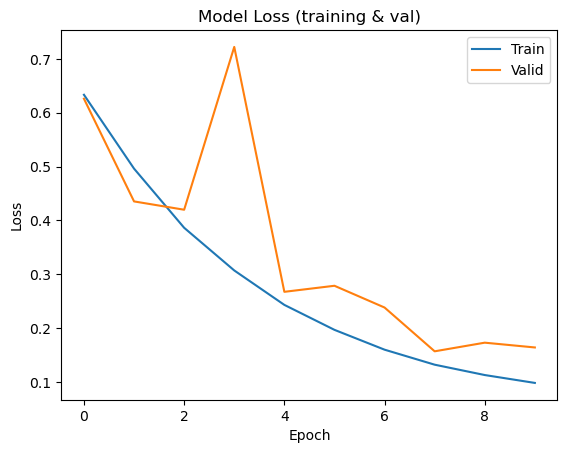

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [28]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=1,
    #color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [29]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

20000/20000 [==============================] - 273s 14ms/step


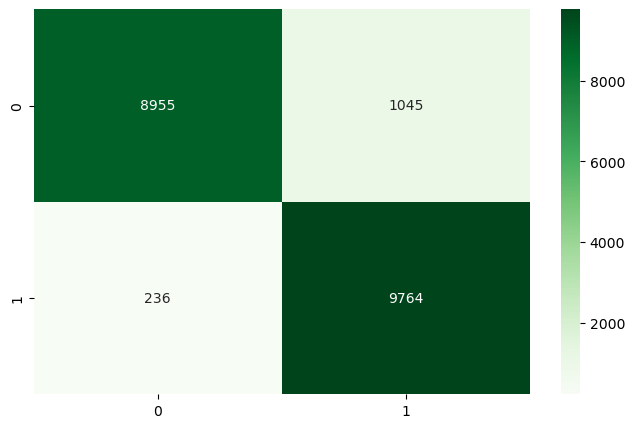

In [30]:
import seaborn as sns
from sklearn import metrics

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [31]:
print("Accuracy score:", metrics.accuracy_score(y_test, y_pred.round()))
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred.round()))


Accuracy score: 0.93595
ROC-AUC Score: 0.93595


Not too much bad but we can do better

# DenseNet fine-tuning 

Now let's load the pretrained model, without its top layers, and replace them with our own, for the binary classification task:

In [14]:
densenet_ft = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_shape=(256,256,3))

model_ft = tf.keras.models.Sequential([ 
        data_augmentation, #augmentation layer
        rescaling, #rescaling layer
        densenet_ft, #model architecture
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

29084464/29084464 [==============================] - 0s 0us/step


In [15]:
model_ft.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [16]:
history_ft = model_ft.fit(train_ds, epochs = 10 , validation_data = valid_ds)

Epoch 1/10
3125/3125 [==============================] - 906s 264ms/step - loss: 0.2101 - accuracy: 0.9112 - val_loss: 0.1739 - val_accuracy: 0.9280
Epoch 2/10
3125/3125 [==============================] - 793s 254ms/step - loss: 0.1033 - accuracy: 0.9603 - val_loss: 0.1102 - val_accuracy: 0.9555
Epoch 3/10
3125/3125 [==============================] - 800s 256ms/step - loss: 0.0783 - accuracy: 0.9702 - val_loss: 0.1502 - val_accuracy: 0.9413
Epoch 4/10
3125/3125 [==============================] - 782s 250ms/step - loss: 0.0604 - accuracy: 0.9769 - val_loss: 0.7491 - val_accuracy: 0.7562
Epoch 5/10
3125/3125 [==============================] - 790s 253ms/step - loss: 0.0488 - accuracy: 0.9817 - val_loss: 0.0772 - val_accuracy: 0.9706
Epoch 6/10
3125/3125 [==============================] - 785s 251ms/step - loss: 0.0414 - accuracy: 0.9846 - val_loss: 0.0405 - val_accuracy: 0.9851
Epoch 7/10
3125/3125 [==============================] - 797s 255ms/step - loss: 0.0375 - accuracy: 0.9858 - val_

In [17]:
model_ft.save("./densenet_fine_tuned.h5")

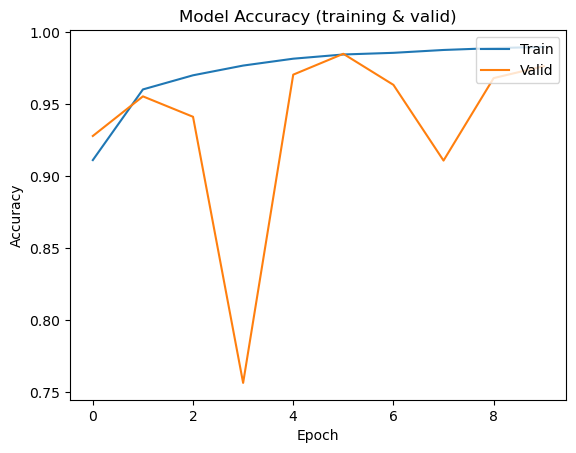

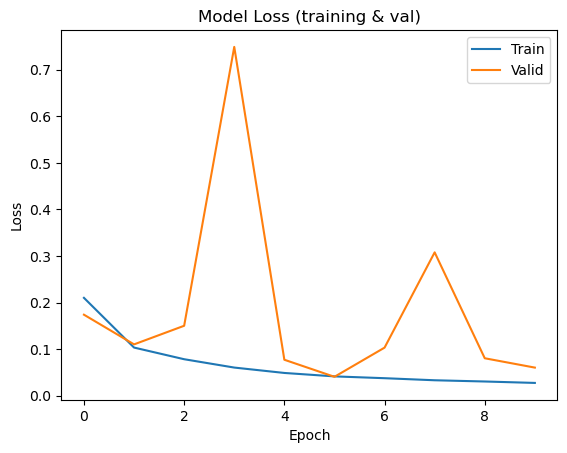

In [18]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [21]:
y_pred_ft = model_ft.predict(test_generator)
y_test_ft = test_generator.classes

20000/20000 [==============================] - 268s 13ms/step


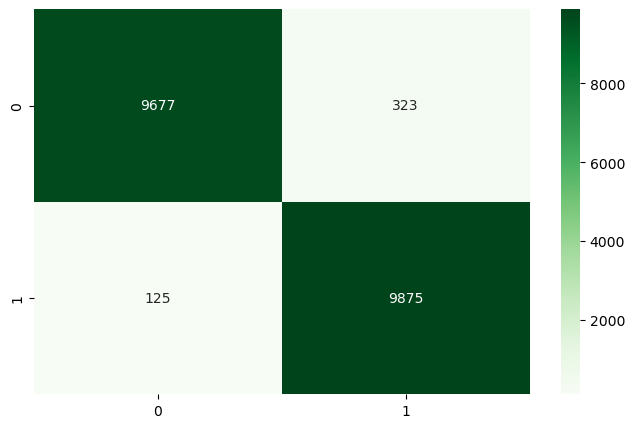

In [23]:
import seaborn as sns
from sklearn import metrics

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test_ft, y_pred_ft.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [24]:
print("Accuracy score:", metrics.accuracy_score(y_test_ft, y_pred_ft.round()))
print("ROC-AUC Score:", metrics.roc_auc_score(y_test_ft, y_pred_ft.round()))

Accuracy score: 0.9776
ROC-AUC Score: 0.9776
